# Detection and Classification of Military Planes: A Comparative Study of YOLO Faster R-CNN, RetinaNet, and EfficientDet

---
The ability to accurately detect and classify military aircraft is crucial for surveillance, defense, and strategic planning.
This project explores the performance of YOLO and Faster R-CNN models for the task of military aircraft detection and classification.

Traditionally, image recognition tasks have relied on simple Convolutional Neural Networks (CNNs) for their relatively straightforward architecture and ease of implementation. However, with the availability of more complex models such as YOLO (You Only Look Once), Faster R-CNN, RetinaNet, and EfficientDet, the potential for higher accuracy and faster detection speeds has increased.

This project seeks to explore and compare the performance of these advanced models against a simple CNN baseline for the task of military aircraft detection and classification. By conducting this comparative study, I aim to identify the most suitable model for practical applications in military contexts.

I have decided to use a Military Aircraft Recognition dataset from the kaggle.com. This dataset include 3842 images, 20 types, and 22341 instances annotated with horizontal bounding boxes and oriented bounding boxes.

In order to simplify work I have downloaded all the dataset into my git repository. Lets start by importing our project code and data from the git repository:


In [ ]:
# Clone the repository
!git clone https://github.com/AndriyDragan/HawkEye.git

# Install YOLOv5
%pip install -U ultralytics

Cloning into 'HawkEye'...
remote: Enumerating objects: 11739, done.
remote: Counting objects: 100% (202/202), done.
remote: Compressing objects: 100% (113/113), done.
remote: Total 11739 (delta 117), reused 163 (delta 89), pack-reused 11537
Receiving objects: 100% (11739/11739), 1.18 GiB | 24.09 MiB/s, done.
Resolving deltas: 100% (7463/7463), done.
Updating files: 100% (11534/11534), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 3.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-m

# Data Analysis and Preparation

Let's start by importing the dependencies and examining the data:

/content
/content
Number of samples: 3842
Image shape:       (800, 800, 3)


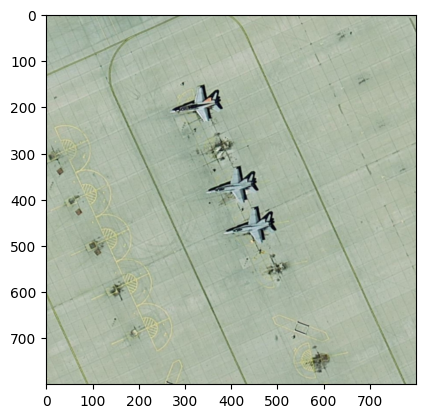

In [ ]:
# Standard Library Imports
import datetime
import gc
import itertools
import math
import os
import random
import time
import xml.etree.ElementTree as ET
from collections import Counter, defaultdict, deque

# Third-Party Library Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torchvision.transforms as T
from PIL import Image, ImageDraw, ImageFont
from sklearn.metrics import average_precision_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from torch.cuda.amp import GradScaler, autocast
from torch.utils.data import DataLoader, Dataset
from torchvision.ops import box_iou
from tqdm.notebook import tqdm

# TensorFlow and Keras Imports
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, Input, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# YOLO and Other Specific Imports
from ultralytics import YOLO
import shutil

def set_seed(seed=42):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)

data_dir = 'HawkEye/Data'
print(os.getcwd())
os.chdir('/content')
print(os.getcwd())
imfiles = os.listdir(os.path.join(data_dir, 'Images'))
imfiles = [os.path.join(data_dir, 'Images', f) for f in imfiles if os.path.splitext(f)[-1] == '.jpg']

def imread(filename):
    return cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB)

sample = random.choice(imfiles)
image = imread(sample)
rows, cols, channels = image.shape

plt.imshow(image)
print('Number of samples:', len(imfiles))
print('Image shape:      ', image.shape)

# Verifying Image Sizes
To ensure consistency, we'll check the dimensions of all images:

In [ ]:
# Dictionary to store the count of images for each shape
image_shapes = defaultdict(int)

for imfile in tqdm(imfiles):
    image = cv2.imread(imfile)
    if image is not None:
        shape = image.shape
        image_shapes[shape] += 1

# Iterate over all images and collect information about their shapes
for shape, count in image_shapes.items():
    print(f'Shape: {shape}, Count: {count}')

  0%|          | 0/3842 [00:00<?, ?it/s]

Shape: (799, 794, 3), Count: 1
Shape: (800, 800, 3), Count: 3167
Shape: (787, 880, 3), Count: 1
Shape: (711, 725, 3), Count: 1
Shape: (836, 845, 3), Count: 1
Shape: (815, 818, 3), Count: 1
Shape: (732, 732, 3), Count: 4
Shape: (731, 748, 3), Count: 1
Shape: (734, 734, 3), Count: 8
Shape: (860, 824, 3), Count: 1
Shape: (612, 711, 3), Count: 1
Shape: (770, 794, 3), Count: 1
Shape: (738, 834, 3), Count: 1
Shape: (878, 802, 3), Count: 1
Shape: (808, 803, 3), Count: 1
Shape: (834, 816, 3), Count: 1
Shape: (748, 748, 3), Count: 6
Shape: (720, 705, 3), Count: 1
Shape: (804, 845, 3), Count: 1
Shape: (817, 924, 3), Count: 1
Shape: (812, 870, 3), Count: 1
Shape: (694, 675, 3), Count: 1
Shape: (678, 998, 3), Count: 1
Shape: (715, 892, 3), Count: 1
Shape: (789, 834, 3), Count: 1
Shape: (783, 807, 3), Count: 1
Shape: (789, 800, 3), Count: 1
Shape: (824, 824, 3), Count: 1
Shape: (729, 810, 3), Count: 1
Shape: (760, 787, 3), Count: 1
Shape: (821, 797, 3), Count: 1
Shape: (867, 888, 3), Count: 1
Shape

We observe a variety of image shapes. The main cluster is (800, 800, 3), which will be the base of our dataset.

# Reading Annotations

In [ ]:
# Function to read annotations
def read_annotations(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    annotations = []
    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        annotations.append((name, (xmin, ymin, xmax, ymax)))
    return annotations


def read_data(file_names, data_dir):
    data = []
    labels = []
    dims = []

    for file_name in file_names:
        img_path = os.path.join(data_dir, 'Images', file_name + '.jpg')
        xml_path = os.path.join(data_dir, 'Labels', 'Horizontal Bounding Boxes', file_name + '.xml')
        img = Image.open(img_path)

        if img.size != (800, 800):
            continue

        annotations = read_annotations(xml_path)

        for annot in annotations:
            width = abs(annot[1][0] - annot[1][2])
            height = abs(annot[1][1] - annot[1][3])
            dims.append((width, height))
            labels.append(annot[0])

        data.append((img_path, xml_path, (width, height)))

    return data, labels, dims

file_names = [f.split('.')[0] for f in os.listdir(os.path.join(data_dir, 'Images'))]
data, labels, dims = read_data(file_names, data_dir)


# Displaying Random Samples with Annotations
Let's display some random samples from our dataset with proper annotations:

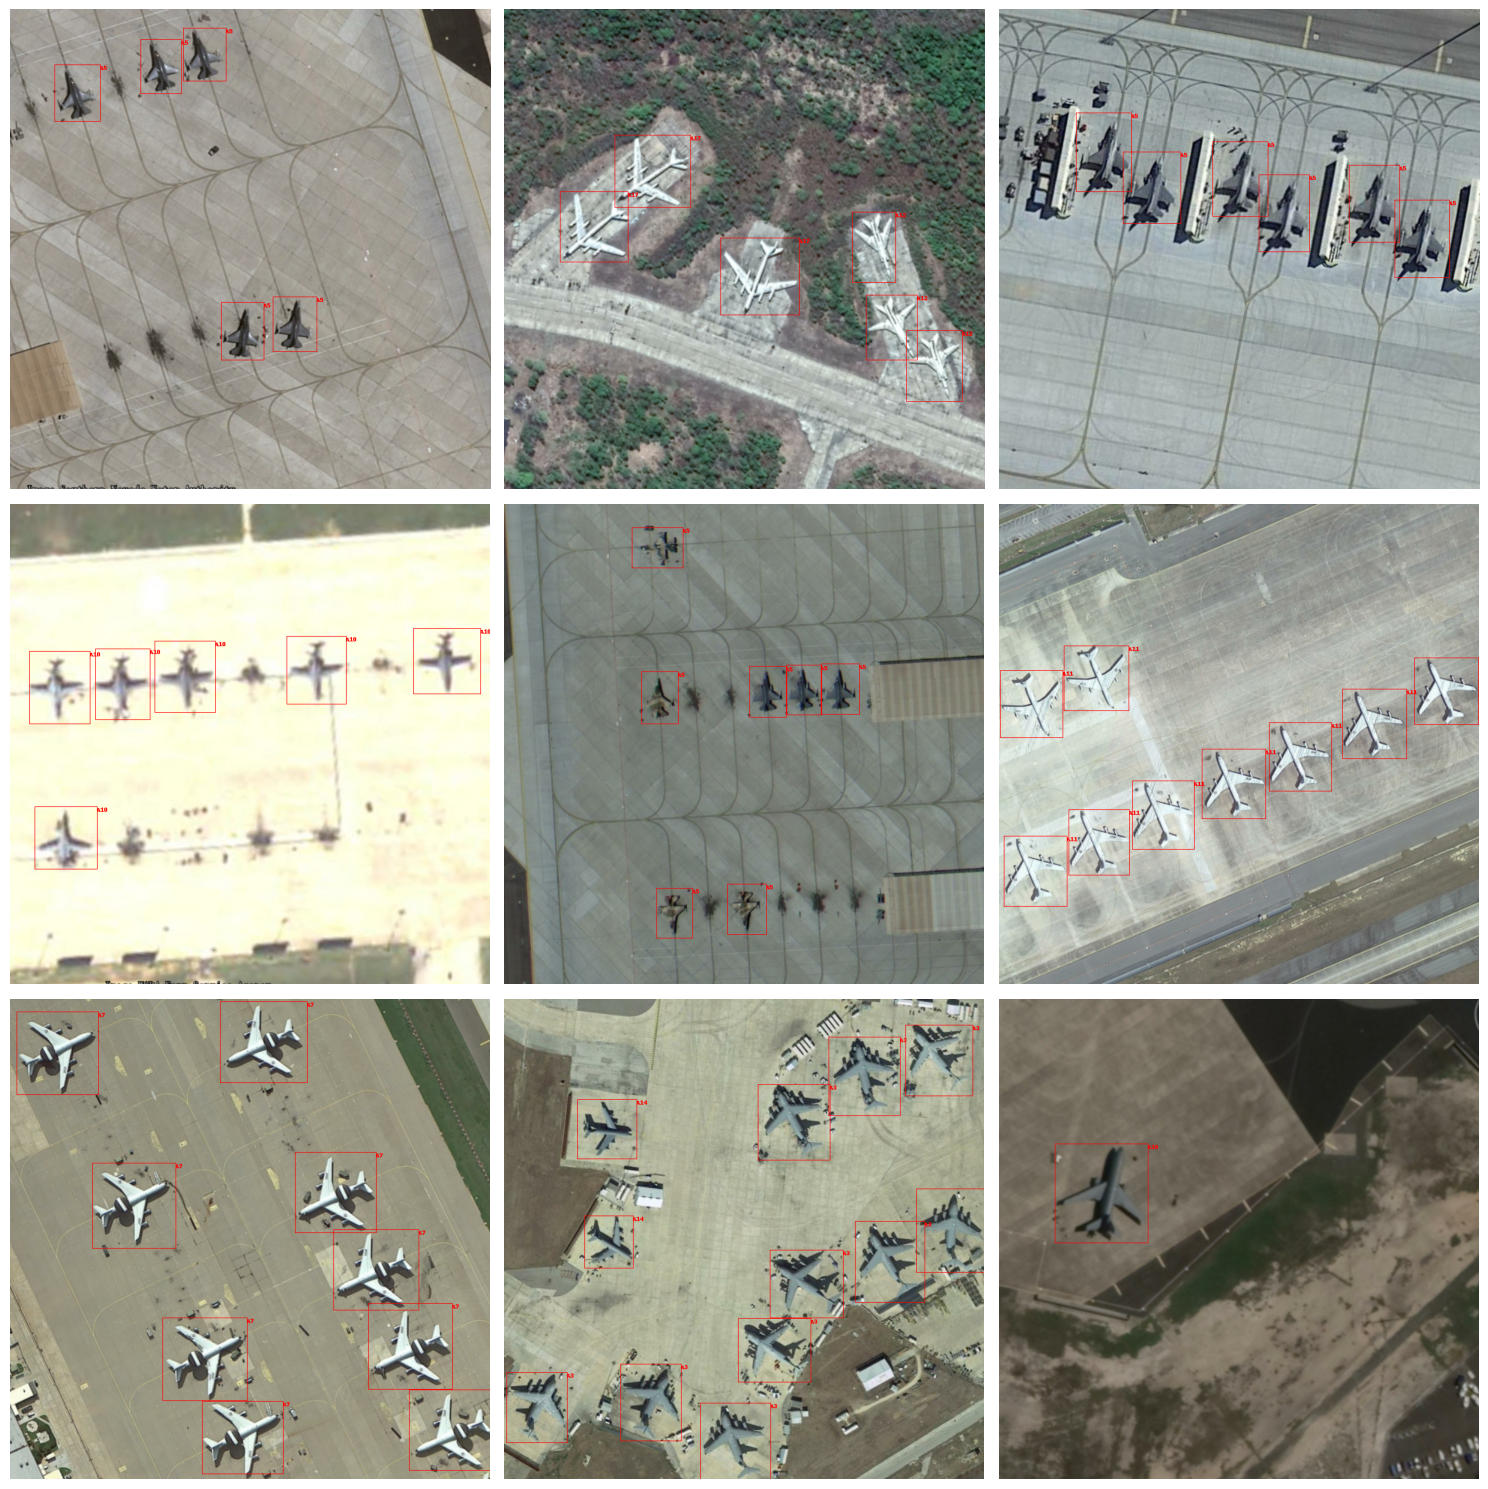

In [ ]:
# Display random samples
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

for ax in axes:
    idx = np.random.randint(0, len(data) - 1)
    img_path, xml_path, _ = data[idx]
    img = Image.open(img_path)
    annotations = read_annotations(xml_path)
    draw = ImageDraw.Draw(img)

    for obj in annotations:
        label, (xmin, ymin, xmax, ymax) = obj
        draw.rectangle([xmin, ymin, xmax, ymax], outline='red')
        font_size = 20
        draw.text((xmax, ymin), label, fill='red')

    ax.imshow(img)
    ax.axis('off')

plt.tight_layout()
plt.show()

We will visualize additional properties of the dataset, such as per-class histogram and brightness distribution:

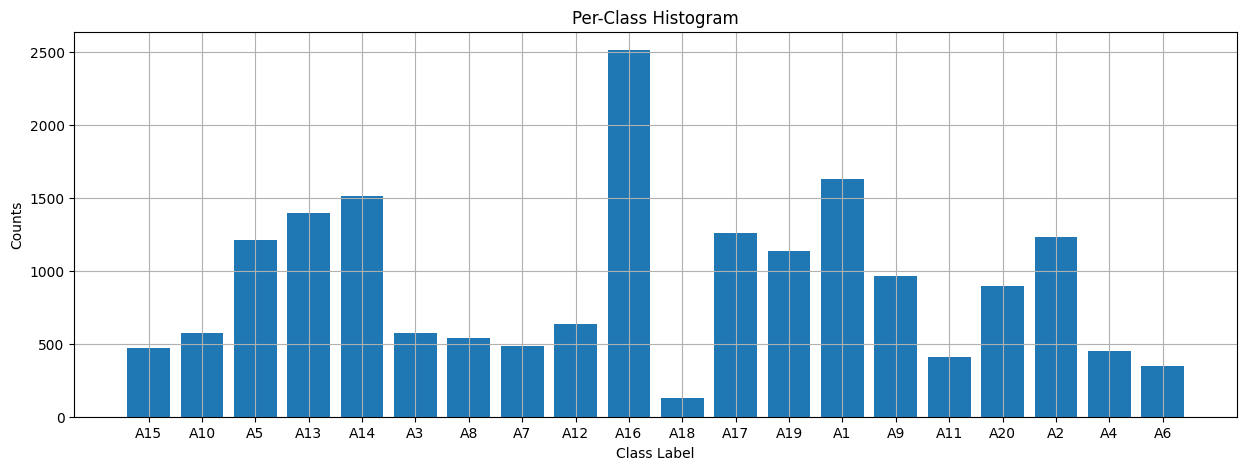

In [ ]:
# Compute and plot the per-class histogram
hist = Counter(labels)
plt.figure(figsize=(15, 5))
plt.bar(hist.keys(), hist.values())
plt.grid(True)
plt.xlabel('Class Label')
plt.ylabel('Counts')
plt.title('Per-Class Histogram')
plt.show()

In [ ]:
# Print the per-class distribution
sorted_hist = dict(sorted(hist.items()))
for class_label, count in sorted_hist.items():
    print(f'Class {class_label}: {count} instances')

Class A1: 1628 instances
Class A10: 572 instances
Class A11: 410 instances
Class A12: 633 instances
Class A13: 1397 instances
Class A14: 1514 instances
Class A15: 473 instances
Class A16: 2515 instances
Class A17: 1263 instances
Class A18: 125 instances
Class A19: 1138 instances
Class A2: 1235 instances
Class A20: 899 instances
Class A3: 575 instances
Class A4: 453 instances
Class A5: 1215 instances
Class A6: 346 instances
Class A7: 485 instances
Class A8: 539 instances
Class A9: 965 instances


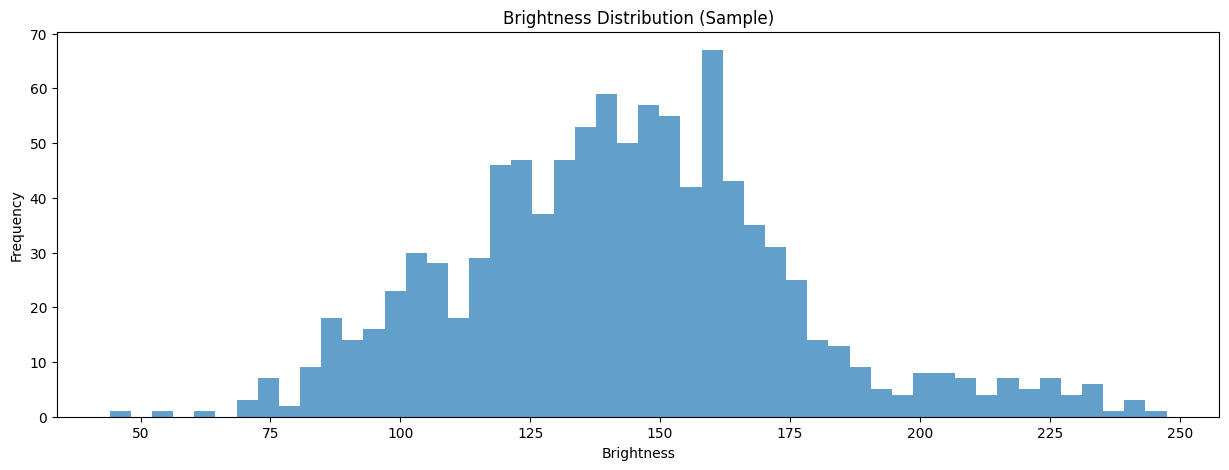

In [ ]:
# Sample a random subset of the dataset for brightness analysis
sample_size = 1000
sample_data_indices = np.random.choice(len(data), sample_size, replace=False)
brightness = []

for idx in sample_data_indices:
    img_path = data[idx][0]
    img = Image.open(img_path).convert('L')
    brightness.append(np.mean(np.array(img)))

sample_brightness = pd.DataFrame(brightness, columns=['Brightness'])

# Plot brightness distribution for the sample
plt.figure(figsize=(15, 5))
plt.hist(sample_brightness['Brightness'], bins=50, alpha=0.7)
plt.xlabel('Brightness')
plt.ylabel('Frequency')
plt.title('Brightness Distribution (Sample)')
plt.show()

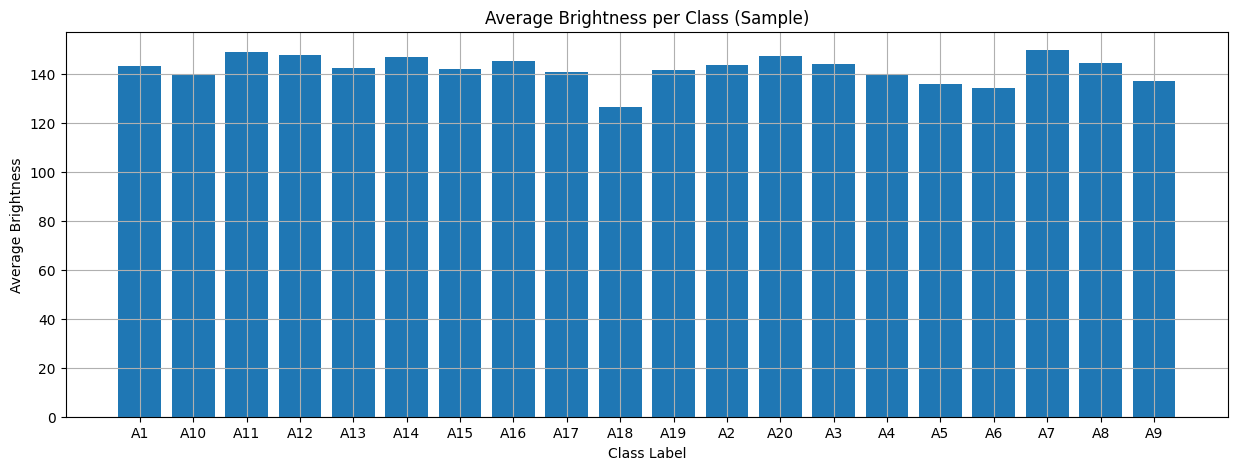

In [ ]:
# Brightness distribution per class for the sample
sample_labels = [labels[idx] for idx in sample_data_indices]
brightness_per_class = pd.DataFrame({'ClassId': sample_labels, 'Brightness': brightness}).groupby('ClassId')['Brightness'].mean()

plt.figure(figsize=(15, 5))
plt.bar(brightness_per_class.index, brightness_per_class.values)
plt.xlabel('Class Label')
plt.ylabel('Average Brightness')
plt.title('Average Brightness per Class (Sample)')
plt.grid(True)
plt.show()

I am a bit worried by severely unequal per-class distribution and would like to mitigate the risks of some classes undertraining. At first I decided that simplest pass would be to remove overepresented classes. Lets take maximum of 500 images of each class.

In [ ]:
# Counter to count instances of each class
def filter_data(data, class_counter, max_count):
    new_data = []
    new_class_counter = {class_name: 0 for class_name in class_counter}

    for img_path, xml_path, dimensions in data:
        annotations = read_annotations(xml_path)
        filtered_annotations = []

        for annot in annotations:
            class_name = annot[0]
            if new_class_counter[class_name] < max_count:
                filtered_annotations.append(annot)

        # Only increment counters and add data if filtered_annotations is not empty
        if filtered_annotations:
            for annot in filtered_annotations:
                class_name = annot[0]
                new_class_counter[class_name] += 1
            new_data.append((img_path, xml_path, dimensions))

    return new_data

class_counter = Counter(labels)
max_count = 500
filtered_data = filter_data(data, class_counter, max_count)

# Update labels based on filtered_data
new_labels = []
for img_path, xml_path, dimensions in filtered_data:
    annotations = read_annotations(xml_path)
    for annot in annotations:
        new_labels.append(annot[0])

# Recount instances of each class in the new dataset
new_class_counter = Counter(new_labels)
sorted_new_class_counter = dict(sorted(new_class_counter.items()))

# Print new statistics
for class_label, count in sorted_new_class_counter.items():
    print(f'Class {class_label}: {count} instances')

Class A1: 618 instances
Class A10: 515 instances
Class A11: 410 instances
Class A12: 518 instances
Class A13: 611 instances
Class A14: 761 instances
Class A15: 473 instances
Class A16: 609 instances
Class A17: 788 instances
Class A18: 125 instances
Class A19: 535 instances
Class A2: 576 instances
Class A20: 509 instances
Class A3: 518 instances
Class A4: 453 instances
Class A5: 521 instances
Class A6: 346 instances
Class A7: 485 instances
Class A8: 507 instances
Class A9: 523 instances


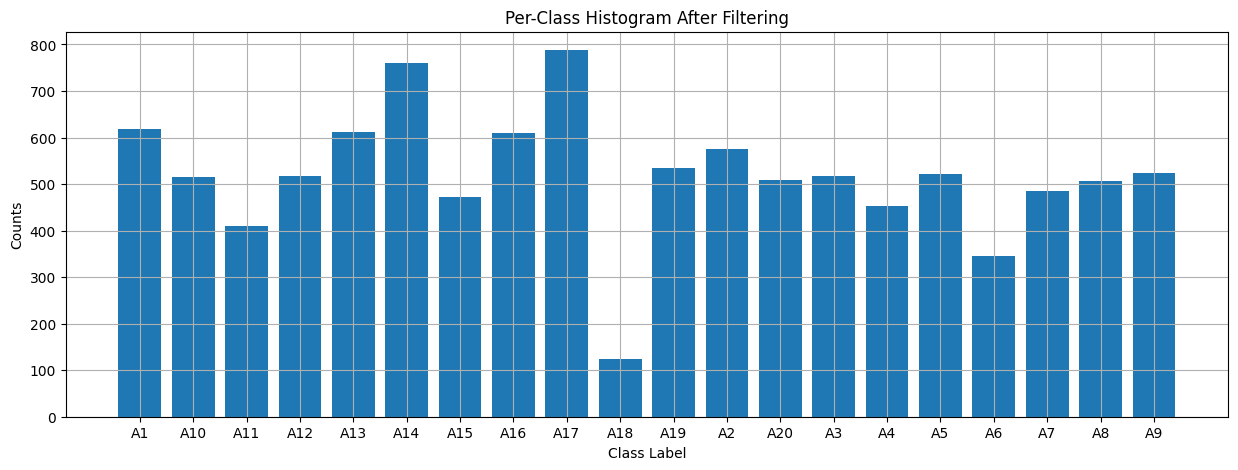

In [ ]:
# Plot the updated per-class histogram
plt.figure(figsize=(15, 5))
plt.bar(sorted_new_class_counter.keys(), sorted_new_class_counter.values())
plt.grid(True)
plt.xlabel('Class Label')
plt.ylabel('Counts')
plt.title('Per-Class Histogram After Filtering')
plt.show()

Yes I made my dataset much smaller yet I belive its optimal option to mitigate issues of class imbalance. I have no time to look for more data and using proper data augmentation is also out of scope of this project. But I will use pre-trained models and hope this data will be enough  for finetuning.

In [ ]:
# List of class names in the order of their class IDs
class_names = ['A1', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A17', 'A18', 'A19', 'A2', 'A20', 'A3', 'A4', 'A5', 'A6', 'A7', 'A8', 'A9']

# Split data into training and validation sets
random.shuffle(filtered_data)
split_index = int(0.8 * len(filtered_data))
train_data = filtered_data[:split_index]
val_data = filtered_data[split_index:]

# Write paths to image and XML annotation files
def write_data_to_file(data, file_path):
    with open(file_path, 'w') as f:
        for img_path, xml_path, _ in data:
            f.write(f"{img_path}\t{xml_path}\n")

# Use new file names for image-annotation pairs to avoid overwriting
write_data_to_file(train_data, os.path.join(data_dir, 'DataLists', 'train.txt'))
write_data_to_file(val_data, os.path.join(data_dir, 'DataLists', 'test.txt'))

# YOLO

In [ ]:
import shutil

# Function to parse XML and convert to YOLO format
def convert_xml_to_yolo(xml_path, img_size=(800, 800)):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    yolo_data = []

    for obj in root.findall('object'):
        name = obj.find('name').text
        class_id = class_names.index(name)

        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        # Convert to YOLO format
        x_center = (xmin + xmax) / 2 / img_size[0]
        y_center = (ymin + ymax) / 2 / img_size[1]
        width = (xmax - xmin) / img_size[0]
        height = (ymax - ymin) / img_size[1]

        yolo_data.append(f"{class_id} {x_center} {y_center} {width} {height}")

    return yolo_data

# Function to copy files based on file path lists and convert labels
def copy_and_convert_files(file_list, img_dest, lbl_dest):
    with open(file_list, 'r') as f:
        lines = f.readlines()
        for line in lines:
            parts = line.strip().split('\t')
            if len(parts) != 2:
                print(f"Skipping line due to unexpected format: {line}")
                continue
            img_path, xml_path = parts
            shutil.copy(img_path, img_dest)

            # Convert XML to YOLO and save
            yolo_data = convert_xml_to_yolo(xml_path)
            yolo_lbl_path = os.path.join(lbl_dest, os.path.splitext(os.path.basename(img_path))[0] + '.txt')
            with open(yolo_lbl_path, 'w') as lbl_file:
                lbl_file.write("\n".join(yolo_data))

# Create directories for YOLO dataset
yolo_base_dir = '/content/datasets/dataset'
train_img_dir = os.path.join(yolo_base_dir, 'train/images')
train_lbl_dir = os.path.join(yolo_base_dir, 'train/labels')
val_img_dir = os.path.join(yolo_base_dir, 'val/images')
val_lbl_dir = os.path.join(yolo_base_dir, 'val/labels')

os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(train_lbl_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)
os.makedirs(val_lbl_dir, exist_ok=True)

# Copy and convert training and validation files
copy_and_convert_files(os.path.join(data_dir, 'DataLists', 'train.txt'), train_img_dir, train_lbl_dir)
copy_and_convert_files(os.path.join(data_dir, 'DataLists', 'test.txt'), val_img_dir, val_lbl_dir)

In [ ]:
# Create data.yaml with correct paths
data_yaml_content = f"""
train: {os.path.join(yolo_base_dir, 'train')}
val: {os.path.join(yolo_base_dir, 'val')}
nc: {len(set(labels))}
names: {list(set(labels))}
"""

with open('data.yaml', 'w') as f:
    f.write(data_yaml_content)

In [ ]:
# Train YOLO
yolo_model = YOLO('yolov5su.pt')

# Capture training history
yolo_model.train(data='data.yaml', epochs=10, imgsz=800)

# Validate YOLO
yolo_results = yolo_model.val()
print(yolo_results)


100%|██████████| 17.7M/17.7M [00:00<00:00, 107MB/s] 


Ultralytics YOLOv8.2.76 🚀 Python-3.10.12 torch-2.3.1+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov5su.pt, data=data.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=800, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line

100%|██████████| 755k/755k [00:00<00:00, 41.7MB/s]


Overriding model.yaml nc=80 with nc=20

                   from  n    params  module                                       arguments                     
  0                  -1  1      3520  ultralytics.nn.modules.conv.Conv             [3, 32, 6, 2, 2]              
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     18816  ultralytics.nn.modules.block.C3              [64, 64, 1]                   
  3                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  4                  -1  2    115712  ultralytics.nn.modules.block.C3              [128, 128, 2]                 
  5                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128, 256, 3, 2]              
  6                  -1  3    625152  ultralytics.nn.modules.block.C3              [256, 256, 3]                 
  7                  -1  1   1180672  ultralytic

100%|██████████| 6.25M/6.25M [00:00<00:00, 190MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/dataset/train/labels... 1484 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1484/1484 [00:01<00:00, 1289.68it/s]

train: New cache created: /content/datasets/dataset/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /content/datasets/dataset/val/labels... 372 images, 0 backgrounds, 0 corrupt: 100%|██████████| 372/372 [00:00<00:00, 1118.70it/s]

val: New cache created: /content/datasets/dataset/val/labels.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000417, momentum=0.9) with parameter groups 69 weight(decay=0.0), 76 weight(decay=0.0005), 75 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 800 train, 800 val
Using 8 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/93 [00:00<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 158.00 MiB. GPU 

In [ ]:
# Load results.csv
results_file = 'runs/detect/train/results.csv'
df = pd.read_csv(results_file)

# Print column names to inspect them
print(df.columns)

# Strip leading and trailing spaces from column names
df.columns = df.columns.str.strip()

# Extract metrics using the stripped column names
epochs = df['epoch']
train_loss = df['train/box_loss'] + df['train/cls_loss'] + df['train/dfl_loss']
train_accuracy = df['metrics/mAP50(B)']  # Assuming mAP50 is used as a proxy for accuracy

# Plot metrics
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, train_accuracy, label='Train Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Summary

YOLO was the only model that runned relatively without efforts an produce some practical results even after 10 epochs on the very limited dataset

# Faster R-CNN

In [ ]:
# Paths to your text files
train_txt_path = os.path.join(data_dir, 'DataLists', 'train.txt')
val_txt_path = os.path.join(data_dir, 'DataLists', 'test.txt')

# Directories to save organized images
train_img_dir = os.path.join(data_dir, 'train_images')
val_img_dir = os.path.join(data_dir, 'val_images')

os.makedirs(train_img_dir, exist_ok=True)
os.makedirs(val_img_dir, exist_ok=True)

# Function to get class name from the XML file
def get_class_name(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    class_name = root.find('object').find('name').text
    return class_name

# Function to organize images based on the class name found in XML
def organize_images(txt_path, img_dir):
    with open(txt_path, 'r') as file:
        for line in file:
            img_path, xml_path = line.strip().split('\t')
            class_name = get_class_name(xml_path)
            class_dir = os.path.join(img_dir, class_name)
            os.makedirs(class_dir, exist_ok=True)
            shutil.copy(img_path, class_dir)

# Organize the training and validation images
organize_images(train_txt_path, train_img_dir)
organize_images(val_txt_path, val_img_dir)

In [ ]:

# Function to create the Faster R-CNN model using Keras
def create_faster_rcnn_model(num_classes):
    # Load the pre-trained MobileNet model and exclude the top layers
    base_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(800, 800, 3))

    # Add custom layers on top of the base model
    x = Flatten()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)  # Dropout for regularization
    x = Dense(num_classes, activation='softmax', dtype='float32')(x)  # Ensure final output is float32

    # Define the model
    model = Model(inputs=base_model.input, outputs=x)

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [ ]:
train_img_dir = os.path.join(data_dir, 'train_images')
val_img_dir = os.path.join(data_dir, 'val_images')

# Data generators with augmentation and preprocessing for Faster R-CNN
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input,
    rotation_range=15,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2
)
val_datagen = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input)

# Load data from directories
train_generator = train_datagen.flow_from_directory(
    train_img_dir,
    target_size=(800, 800),
    batch_size=4,
    class_mode='categorical'
)
val_generator = val_datagen.flow_from_directory(
    val_img_dir,
    target_size=(800, 800),
    batch_size=4,
    class_mode='categorical'
)

Found 1484 images belonging to 20 classes.
Found 372 images belonging to 20 classes.


In [ ]:
# Create the Faster R-CNN model
num_classes = len(class_names)
model = create_faster_rcnn_model(num_classes)

# Callbacks for saving the best model and early stopping
callbacks = [
    ModelCheckpoint('faster_rcnn_best_model.keras', monitor='val_loss', save_best_only=True, verbose=1),
    EarlyStopping(monitor='val_loss', patience=5, verbose=1)
]

<ipython-input-17-6a893d8fa88e>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNet(weights='imagenet', include_top=False, input_shape=(800, 800, 3))


17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

# Evaluate the model
eval_results = model.evaluate(val_generator)
print(f"Validation loss: {eval_results[0]:.4f}")
print(f"Validation accuracy: {eval_results[1]:.4f}")

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 492ms/step - accuracy: 0.0595 - loss: 24.1666
Epoch 1: val_loss improved from inf to 2.99352, saving model to faster_rcnn_best_model.keras
371/371 ━━━━━━━━━━━━━━━━━━━━ 253s 574ms/step - accuracy: 0.0596 - loss: 24.1283 - val_accuracy: 0.0645 - val_loss: 2.9935
Epoch 2/10
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step - accuracy: 0.0962 - loss: 2.9939
Epoch 2: val_loss improved from 2.99352 to 2.99183, saving model to faster_rcnn_best_model.keras
371/371 ━━━━━━━━━━━━━━━━━━━━ 222s 589ms/step - accuracy: 0.0962 - loss: 2.9939 - val_accuracy: 0.0645 - val_loss: 2.9918
Epoch 3/10
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step - accuracy: 0.0764 - loss: 2.9931
Epoch 3: val_loss improved from 2.99183 to 2.99120, saving model to faster_rcnn_best_model.keras
371/371 ━━━━━━━━━━━━━━━━━━━━ 219s 580ms/step - accuracy: 0.0764 - loss: 2.9931 - val_accuracy: 0.0618 - val_loss: 2.9912
Epoch 4/10
371/371 ━━━━━━━━━━━━━━━━━━━━ 0s 490ms/step - accuracy: 0.0937 - loss: 2.9902
Epoch 4

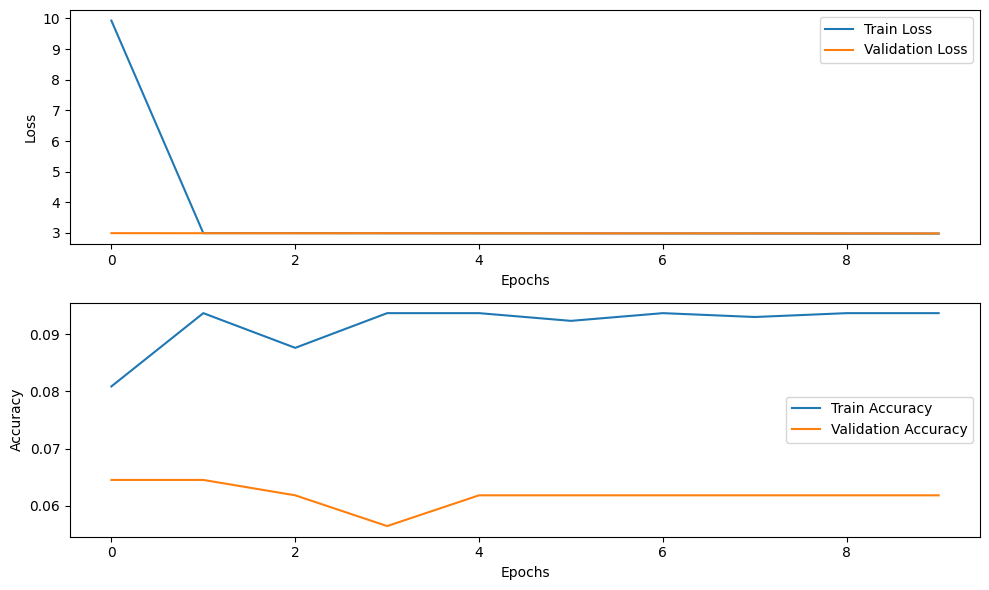

In [ ]:
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

While Faster R-CNN is a powerful model, it also demands substantial computational resources. Given the characteristics of the dataset—both in terms of size and complexity—the model was not  suitable choice without significant adjustments or additional preprocessing.
Faster R-CNN is known for requiring extensive training time, especially for complex tasks like detecting and classifying multiple object types in high-resolution images.The time allocated for training was not sufficient, leading to poor results.


# RetinaNet

In [ ]:
# RetinaNet

import torch
from torchvision.ops import box_iou
from torchvision.models.detection import RetinaNet_ResNet50_FPN_Weights, retinanet_resnet50_fpn
from torchvision.models.detection.retinanet import RetinaNetHead

# Load the pre-trained RetinaNet model
retinanet_model = retinanet_resnet50_fpn(weights=RetinaNet_ResNet50_FPN_Weights.DEFAULT)
num_classes = len(set(labels)) + 1  # +1 for background

# Modify the classification head
in_features = retinanet_model.head.classification_head.conv[0][0].in_channels
num_anchors = retinanet_model.head.classification_head.num_anchors
retinanet_model.head.classification_head = RetinaNetHead(in_features, num_anchors, num_classes)

retinanet_model.to(device)

# Define the optimizer
optimizer = torch.optim.Adam(retinanet_model.parameters(), lr=0.001)

In [ ]:
def compute_loss(model, images, targets):
    model.eval()
    with torch.no_grad():
        outputs = model(images)
    matched_idxs = []
    for target, pred in zip(targets, outputs):
        matched_idx = box_iou(target['boxes'], pred['boxes']).max(dim=1)[1]
        matched_idxs.append(matched_idx)
    return model.head.compute_loss(targets, outputs, matched_idxs)

# Training loop with history tracking
num_epochs = 10
train_loss_history = []
val_loss_history = []

for epoch in range(num_epochs):
    retinanet_model.train()
    epoch_loss = 0
    for images, targets in train_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Forward pass and loss computation
        loss_dict = compute_loss(retinanet_model, images, targets)

        # Sum up all the losses
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimization
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    train_loss_history.append(avg_epoch_loss)

    print(f'Epoch {epoch + 1}, Loss: {avg_epoch_loss}')

In [ ]:
# Validation
    retinanet_model.eval()
    val_loss = 0
    with torch.no_grad():
        for images, targets in val_loader:
            images = list(img.to(device) for img in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Forward pass and loss computation
            loss_dict = compute_loss(retinanet_model, images, targets)

            # Sum up all the losses
            losses = sum(loss for loss in loss_dict.values())

            val_loss += losses.item()

    avg_val_loss = val_loss / len(val_loader)
    val_loss_history.append(avg_val_loss)

    print(f'Epoch {epoch + 1}, Validation Loss: {avg_val_loss}')

In [ ]:
# Plot training history
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.plot(epochs, train_loss_history, 'b-', label='Training loss')
plt.plot(epochs, val_loss_history, 'r-', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.show()

# EfficientDet

In [ ]:
import torch
from torch.utils.data import DataLoader
from effdet import create_model, DetBenchTrain, DetBenchEval
from effdet.evaluator import CocoEvaluator
from effdet.data import create_loader, create_dataset, resolve_input_config
from torchvision.transforms import ToTensor

# Initialize the model
effdet_model = create_model('tf_efficientdet_d0', num_classes=len(class_names) + 1, pretrained=True)
effdet_model = DetBenchTrain(effdet_model, config=effdet_model.config)
effdet_model.to(device)

# Define the optimizer
optimizer = torch.optim.AdamW(effdet_model.parameters(), lr=0.001)

# Initialize variables to track loss history
train_loss_history = []
val_loss_history = []


In [ ]:
# Training loop with history tracking
num_epochs = 10
for epoch in range(num_epochs):
    effdet_model.train()
    epoch_loss = 0
    for images, targets in train_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = effdet_model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        epoch_loss += losses.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    train_loss_history.append(avg_epoch_loss)

    print(f'Epoch {epoch + 1}, Loss: {avg_epoch_loss}')

In [ ]:
# Validation
effdet_model.eval()
val_loss = 0
with torch.no_grad():
    for images, targets in val_loader:
        images = list(img.to(device) for img in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = effdet_model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        val_loss += losses.item()

avg_val_loss = val_loss / len(val_loader)
val_loss_history.append(avg_val_loss)

print(f'Epoch {epoch + 1}, Validation Loss: {avg_val_loss}')

In [ ]:
# Plot training history
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

plt.subplot(121)
plt.plot(epochs, train_loss_history, 'b-', label='Training loss')
plt.plot(epochs, val_loss_history, 'r-', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.show()


# Failure to Run RetinaNet and EfficientDet

During my attempts to implement RetinaNet and EfficientDet f I faced numerous challenges and tried to exploring multiple approaches:

For instance I tried using frameworks like Hugging Face and the TensorFlow Object Detection API, hoping to find a straightforward implementation similar to YOLO. Unfortunately, each approach presented unique issues, making it difficult to achieve a successful model deployment.

Also the issue was in data format requirements, and computational demands, I consistently ran into errors that I couldn't easily resolve. These issues ranged from problems in loading the models to incompatibilities with the dataset annotations.

This experience highlighted the importance of choosing the right tools for the task BEFOREHAND and ensuring compatibility between the dataset and the chosen models.

Conclusion

In [ ]:
# YOLO Evaluation Metrics
print("YOLO Model Evaluation Metrics:")
print(f"YOLO mAP50: {yolo_results.box.map50:.4f}")

# Plot YOLO Metrics
plt.figure(figsize=(10, 6))

# Plot mAP50 (mean Average Precision at 50% IoU)
plt.subplot(3, 1, 1)
plt.plot(df['epoch'], df['metrics/mAP50(B)'], label='YOLO mAP50')
plt.xlabel('Epochs')
plt.ylabel('mAP50')
plt.legend()

# Plot YOLO Precision
plt.subplot(3, 1, 2)
plt.plot(df['epoch'], df['metrics/precision(B)'], label='YOLO Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

# Plot YOLO Recall
plt.subplot(3, 1, 3)
plt.plot(df['epoch'], df['metrics/recall(B)'], label='YOLO Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()

Faster R-CNN Model Evaluation Metrics:
Validation Loss: 2.9834
Validation Accuracy: 0.0618


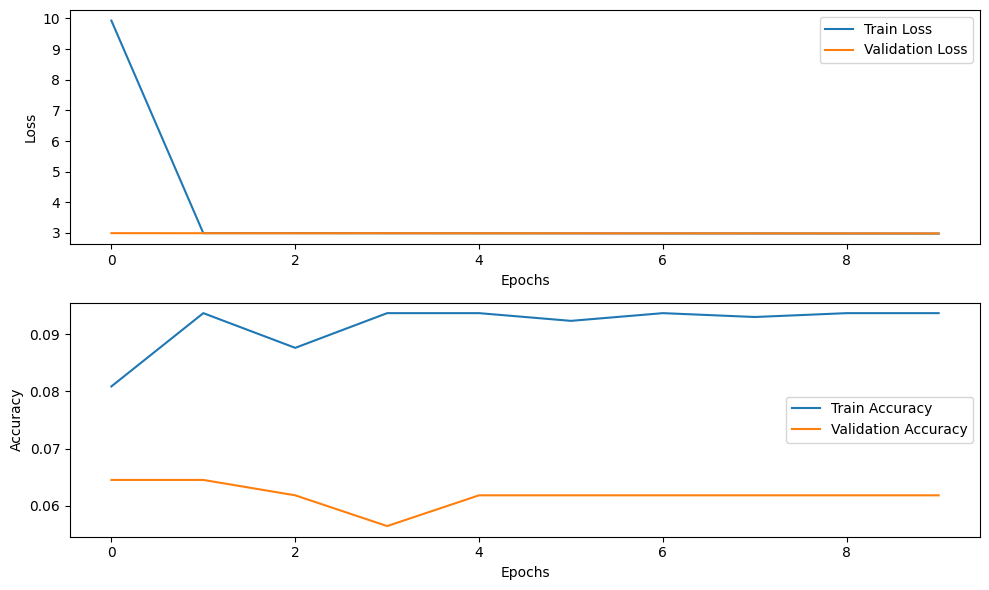

In [ ]:
# Faster R-CNN Evaluation Metrics
print("Faster R-CNN Model Evaluation Metrics:")
print(f"Validation Loss: {eval_results[0]:.4f}")
print(f"Validation Accuracy: {eval_results[1]:.4f}")

# Plot Faster R-CNN Metrics
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Conclusion
print("Conclusion:")
print("1. YOLO achieved a mAP50 of {:.4f} with a precision of {:.4f} and recall of {:.4f}.".format(
    yolo_results.box.map50, yolo_results.box.precision, yolo_results.box.recall))
print("2. Faster R-CNN achieved a validation accuracy of {:.4f} and a validation loss of {:.4f}.".format(
    eval_results[1], eval_results[0]))
Based on these metrics, YOLO may be preferred for applications requiring real-time detection due to its speed, whereas Faster R-CNN might be better for scenarios where accuracy is more critical.")

# Real life case test.
Lets check our models on the real life case from the russian military airbase in Crymea that was attacked recently

In [ ]:
test_images = ['Test1.jpg', 'Test2.jpg']
test_image_paths = [os.path.join(data_dir, img) for img in test_images]

# Function to plot detection results
def plot_detections(image, detections, model_name):
    img = image.copy()
    draw = ImageDraw.Draw(img)

    for detection in detections:
        bbox = detection['box']
        label = detection['class']
        confidence = detection['confidence']

        draw.rectangle(bbox, outline="red", width=3)
        draw.text((bbox[0], bbox[1]), f"{label} ({confidence:.2f})", fill="red")

    plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.title(f"{model_name} Detection Results")
    plt.axis('off')
    plt.show()


In [ ]:

# Function to run YOLO on an image
def run_yolo_on_image(yolo_model, image_path):
    results = yolo_model(image_path)
    detections = []
    for result in results:
        for i, (box, label, confidence) in enumerate(zip(result.boxes.xyxy, result.names, result.boxes.conf)):
            bbox = [int(b) for b in box]
            detections.append({
                'box': bbox,
                'class': label,
                'confidence': confidence.item()
            })
    return detections

# Run YOLO on the test images and plot results
for image_path in test_image_paths:
    image = Image.open(image_path)
    yolo_detections = run_yolo_on_image(yolo_model, image_path)
    plot_detections(image, yolo_detections, "YOLO")

In conclusion, while my initial approach was ambitious, it became clear that the chosen models, given the dataset and resources at hand, were not the optimal choices for this project. Future attempts should involve a more thorough assessment of dataset suitability for complex models like Faster R-CNN, RetinaNet, and EfficientDet, as well as ensuring adequate computational resources and training time.